<a href="https://colab.research.google.com/github/wjficap/wavefront/blob/main/TQQQ_macd_strat_(except_mid_term_oct_jan)_v170924b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dropdown(description='Start Year:', options=(1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,…

Dropdown(description='Start Month:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1)

Dropdown(description='Start Day:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…

Dropdown(description='End Year:', index=44, options=(1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 198…

Dropdown(description='End Month:', index=11, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=12)

Dropdown(description='End Day:', index=30, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

[*********************100%***********************]  1 of 1 completed


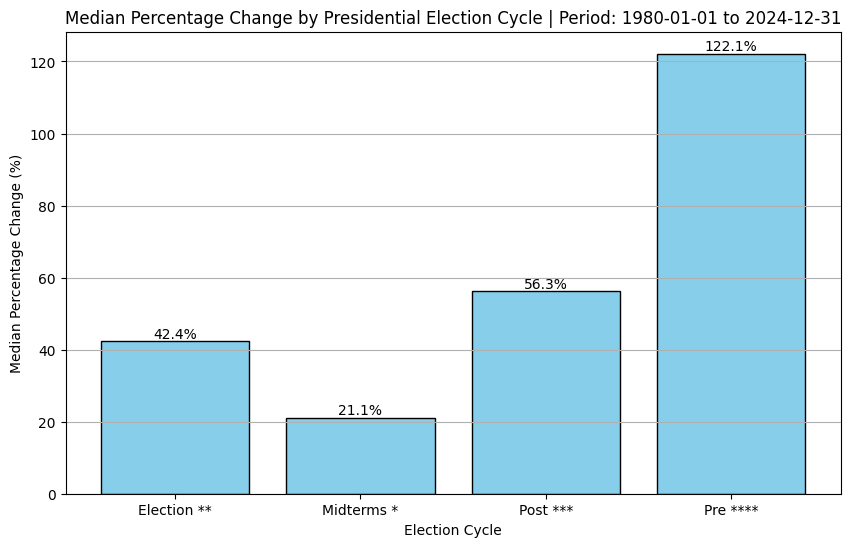

   Start Date   End Date Election Cycle  % Change  Value ($1k)
0  1985-10-14 1986-02-26     Midterms *      92.0         1920
1  1986-10-01 1987-07-24       Pre ****     160.7         5006
2  1987-11-04 1988-10-05    Election **      50.0         7509
3  1988-10-19 1989-07-24       Post ***      56.3        11738
4  1989-11-13 1990-01-11     Midterms *     -12.5        10266
5  1990-10-01 1991-08-19       Pre ****     219.2        32774
6  1991-10-15 1992-07-27    Election **       3.2        33832
7  1992-10-16 1993-07-30       Post ***      34.1        45383
8  1993-10-14 1994-01-25     Midterms *      14.2        51815
9  1994-10-12 1995-07-19       Pre ****     137.7       123185
10 1995-10-17 1996-08-29    Election **      39.7       172044
11 1996-10-14 1997-08-08       Post ***     168.4       461842
12 1997-10-06 1998-03-03     Midterms *       2.3       472693
13 1998-10-15 1999-07-20       Pre ****     406.5      2394322
14 1999-10-07 2000-07-24    Election **      80.8      

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define dropdowns for year, month, and day
years = list(range(1980, 2025))
months = list(range(1, 13))
days = list(range(1, 32))

year_start = widgets.Dropdown(
    options=years,
    value=2015,
    description='Start Year:',
)

month_start = widgets.Dropdown(
    options=months,
    value=1,
    description='Start Month:',
)

day_start = widgets.Dropdown(
    options=days,
    value=1,
    description='Start Day:',
)

year_end = widgets.Dropdown(
    options=years,
    value=2024,
    description='End Year:',
)

month_end = widgets.Dropdown(
    options=months,
    value=12,
    description='End Month:',
)

day_end = widgets.Dropdown(
    options=days,
    value=31,
    description='End Day:',
)

# Function to handle date range updates
def update_data(change):
    clear_output(wait=True)
    display(year_start, month_start, day_start, year_end, month_end, day_end)  # Re-display widgets

    start_date = f'{year_start.value}-{month_start.value:02d}-{day_start.value:02d}'
    end_date = f'{year_end.value}-{month_end.value:02d}-{day_end.value:02d}'

    # Download data from Yahoo Finance
    data = yf.download('^NDX', start=start_date, end=end_date)
    data['Date'] = data.index
    data.reset_index(drop=True, inplace=True)

    # Calculate daily returns and 3x leverage
    data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
    data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

    # Calculate MACD
    def calculate_macd(df, slow=26, fast=12, signal=9):
        df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
        return df

    data = calculate_macd(data)

    # Identify MACD crossovers
    data['MACD_Crossover'] = np.where(
        (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
        np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
    )

    # Step 7: Add presidential election cycle
    def election_cycle(year):
        cycle_year = year % 4
        if cycle_year == 0:
            return 'Election **'
        elif cycle_year == 1:
            return 'Post ***'
        elif cycle_year == 2:
            return 'Midterms *'
        else:
            return 'Pre ****'

    # Find the start and end crossover periods
    def find_crossover_periods(df):
        start_dates = []
        end_dates = []

        min_year = df['Date'].dt.year.min()
        max_year = df['Date'].dt.year.max()

        for year in range(min_year, max_year):
            current_cycle = election_cycle(year)

            if current_cycle == 'Post ***':
                start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
                if not start_filter.empty:
                    start_date = start_filter.iloc[0]['Date']
                    end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                    if not end_filter.empty:
                        end_date = end_filter.iloc[0]['Date']
                        start_dates.append(start_date)
                        end_dates.append(end_date)
            else:
                start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
                if not start_filter.empty:
                    start_date = start_filter.iloc[0]['Date']
                    end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                    if not end_filter.empty:
                        end_date = end_filter.iloc[0]['Date']
                        start_dates.append(start_date)
                        end_dates.append(end_date)

        return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

    macd_periods = find_crossover_periods(data)

    # Add presidential election cycle
    macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

    # Calculate percentage changes with 3x leverage
    percentage_changes_leveraged = []
    funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
    initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

    for index, row in macd_periods.iterrows():
        start_date = row['Start Date']
        end_date = row['End Date']

        period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

        cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
        percentage_changes_leveraged.append(cumulative_return * 100)

        initial_fund_leveraged *= (1 + cumulative_return)
        funds_leveraged.append(initial_fund_leveraged)

    macd_periods['% Change'] = percentage_changes_leveraged
    macd_periods['Value ($1k)'] = funds_leveraged[1:]

    macd_periods['% Change'] = macd_periods['% Change'].round(1)
    macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

    # Aggregate returns by election cycle
    cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
    plt.xlabel('Election Cycle')
    plt.ylabel('Median Percentage Change (%)')
    chart_title = f'Median Percentage Change by Presidential Election Cycle | Period: {year_start.value}-{month_start.value:02d}-{day_start.value:02d} to {year_end.value}-{month_end.value:02d}-{day_end.value:02d}'
    plt.title(chart_title)
    plt.grid(axis='y')

    # Add percentage values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', va='bottom', ha='center')

    plt.show()


    # Output the table with leverage results
    print(macd_periods)

    # Optional: Export to CSV
    macd_periods.to_csv('macd_periods_leveraged.csv', index=False)

# Link widgets to update function
year_start.observe(update_data, names='value')
month_start.observe(update_data, names='value')
day_start.observe(update_data, names='value')
year_end.observe(update_data, names='value')
month_end.observe(update_data, names='value')
day_end.observe(update_data, names='value')

# Display widgets
display(year_start, month_start, day_start, year_end, month_end, day_end)


[*********************100%***********************]  1 of 1 completed


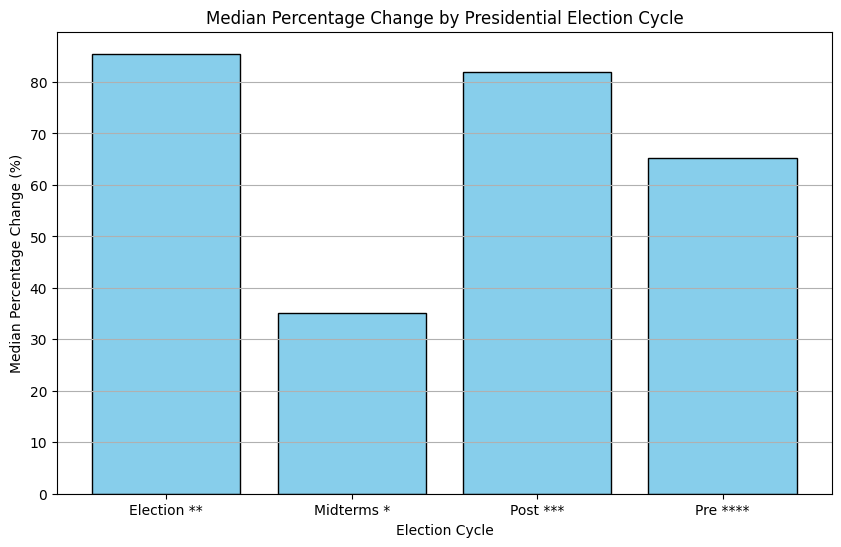

  Start Date   End Date Election Cycle  % Change  Value ($1k)
0 2015-10-05 2016-08-16    Election **      30.8         1308
1 2016-10-10 2017-08-02       Post ***      74.7         2286
2 2017-10-03 2018-02-01     Midterms *      51.8         3469
3 2018-11-02 2019-07-19       Pre ****      23.7         4293
4 2019-10-11 2020-07-17    Election **      85.5         7961
5 2020-11-05 2021-07-27       Post ***      89.2        15059
6 2021-10-14 2022-01-05     Midterms *      18.3        17815
7 2022-10-05 2023-07-21       Pre ****     106.6        36808
8 2023-10-06 2024-09-03    Election **      95.6        71996


In [ ]:
# @title Oct-July except midterms Oct-Jan
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


# Step 1: Download data from Yahoo Finance
start_date = '2015-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Get the election cycle for the current year
        current_cycle = election_cycle(year)

        if current_cycle == 'Post ***':
            # Special case for Post-Election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # End period on January 1 of the midterm year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)
        else:
            # Standard case
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']

                # Now look for the bearish crossover after July 17 of the next year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 7: Add presidential election cycle


macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)



# Step 8 (Revised): Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)

[*********************100%***********************]  1 of 1 completed


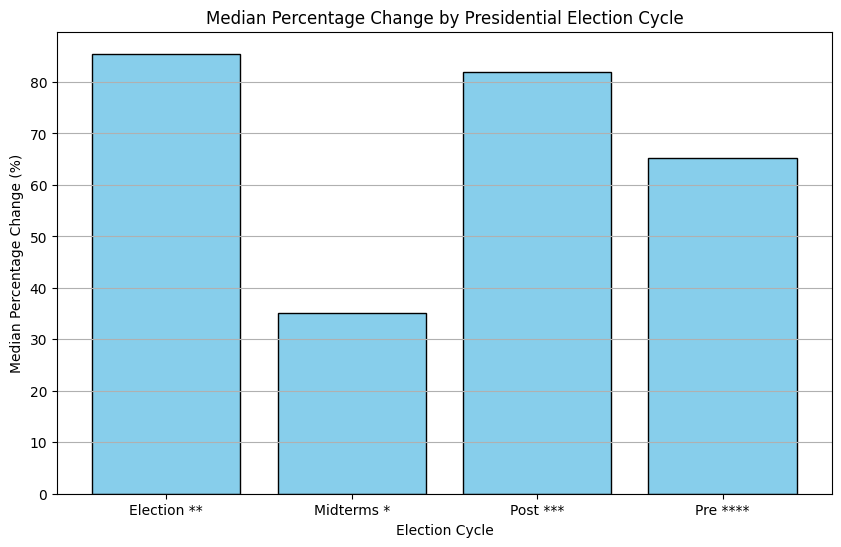

  Start Date   End Date Election Cycle  % Change  Value ($1k)
0 2015-10-05 2016-08-16    Election **      30.8         1308
1 2016-10-10 2017-08-02       Post ***      74.7         2286
2 2017-10-03 2018-02-01     Midterms *      51.8         3469
3 2018-11-02 2019-07-19       Pre ****      23.7         4293
4 2019-10-11 2020-07-17    Election **      85.5         7961
5 2020-11-05 2021-07-27       Post ***      89.2        15059
6 2021-10-14 2022-01-05     Midterms *      18.3        17815
7 2022-10-05 2023-07-21       Pre ****     106.6        36808
8 2023-10-06 2024-09-03    Election **      95.6        71996


In [ ]:
# @title Oct-July except midterms Oct-Jan
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '2015-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Get the election cycle for the current year
        current_cycle = election_cycle(year)

        if current_cycle == 'Post ***':
            # Special case for Post-Election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # End period on January 1 of the midterm year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-01-01')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)
        else:
            # Standard case
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']

                # Now look for the bearish crossover after July 17 of the next year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']

                    # Append the start and end dates
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 7: Add presidential election cycle


macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)



# Step 8 (Revised): Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)

[*********************100%***********************]  1 of 1 completed


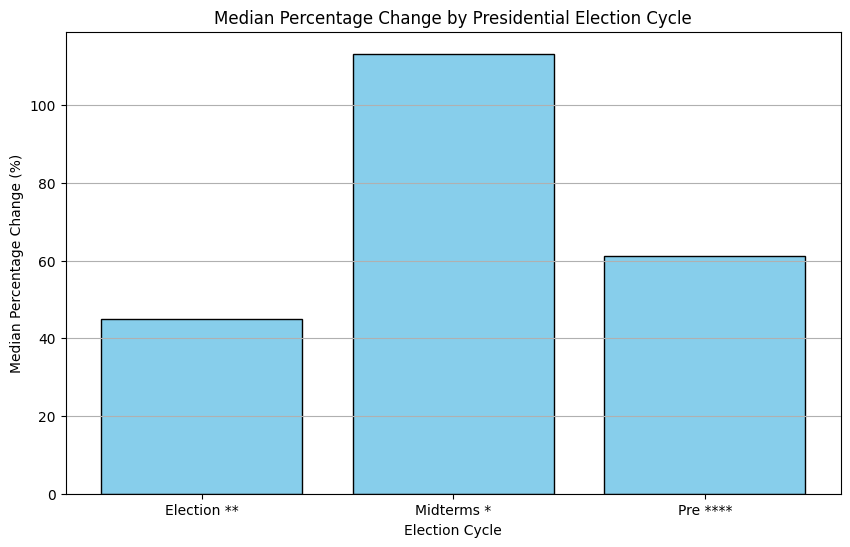

   Start Date   End Date  % Change  Value ($1k) Election Cycle
0  1996-10-14 1998-03-03     175.3         2753     Midterms *
1  1998-10-15 1999-07-20     406.5        13944       Pre ****
2  1999-10-07 2000-07-24      80.8        25211    Election **
3  2000-10-19 2002-01-11     -95.8         1066     Midterms *
4  2002-10-10 2003-07-18     196.7         3164       Pre ****
5  2003-10-07 2004-08-05     -14.5         2705    Election **
6  2004-10-01 2006-01-20      53.6         4156     Midterms *
7  2006-10-05 2007-07-24      61.2         6701       Pre ****
8  2007-10-18 2008-08-25     -45.1         3679    Election **
9  2008-10-20 2010-01-12      87.5         6897     Midterms *
10 2010-10-13 2011-07-28      48.3        10230       Pre ****
11 2011-10-10 2012-07-24      45.0        14835    Election **
12 2012-11-20 2014-01-03     140.2        35639     Midterms *
13 2014-10-22 2015-08-03      46.8        52301       Pre ****
14 2015-10-05 2016-08-16      30.8        68419    Elec

In [ ]:
# @title Oct to July and full Post Election year
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '1996-01-01'
end_date = '2024-12-31'
data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Get the election cycle for the current year
        current_cycle = election_cycle(year)

        if current_cycle == 'Election **':
            # Case 1: Enter on MACD bullish crossover from 1st October of election year
            # Exit on MACD bearish crossover from 2nd January of the midterm year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 2nd January of the midterm year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+2}-01-02')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

        elif current_cycle == 'Midterms *':
            # Case 2: Enter on MACD bullish crossover from 1st October of midterm year
            # Exit on MACD bearish crossover from 17th July of pre-election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 17th July of the pre-election year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

        elif current_cycle == 'Pre ****':
            # Case 3: Enter on MACD bullish crossover from 1st October of pre-election year
            # Exit on MACD bearish crossover from 17th July of election year
            start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
            if not start_filter.empty:
                start_date = start_filter.iloc[0]['Date']
                # Exit should be on or after 17th July of the election year
                end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
                if not end_filter.empty:
                    end_date = end_filter.iloc[0]['Date']
                    start_dates.append(start_date)
                    end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

# Step 6: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

# Step 7: Calculate percentage changes with 3x leverage
macd_periods = find_crossover_periods(data)
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $1000 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 1 decimal place for % and no decimal for value
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 8: Add election cycle to the results
macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 9: Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 10: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)


[*********************100%***********************]  1 of 1 completed


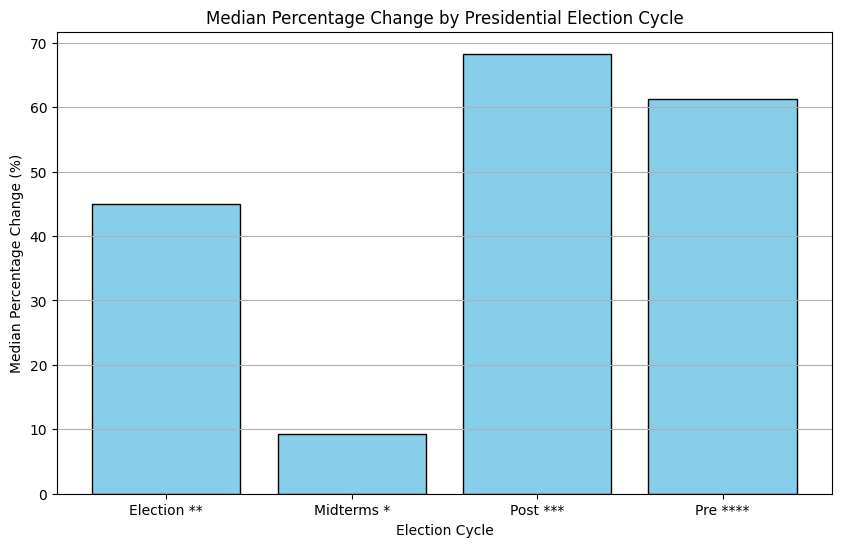

   Start Date   End Date  % Change  Value ($1k) Election Cycle
0  1996-10-14 1997-08-08     168.4         2684       Post ***
1  1997-10-06 1998-07-23      64.1         4404     Midterms *
2  1998-10-15 1999-07-20     406.5        22308       Pre ****
3  1999-10-07 2000-07-24      80.8        40331    Election **
4  2000-10-19 2001-07-18     -94.2         2345       Post ***
5  2001-10-02 2002-07-23     -69.1          725     Midterms *
6  2002-10-10 2003-07-18     196.7         2152       Pre ****
7  2003-10-07 2004-08-05     -14.5         1839    Election **
8  2004-10-01 2005-08-05      37.4         2528       Post ***
9  2005-10-20 2006-09-08      -5.6         2387     Midterms *
10 2006-10-05 2007-07-24      61.2         3849       Pre ****
11 2007-10-18 2008-08-25     -45.1         2113    Election **
12 2008-10-20 2009-08-10      25.6         2654       Post ***
13 2009-10-14 2010-08-11       9.2         2899     Midterms *
14 2010-10-13 2011-07-28      48.3         4300       P

In [ ]:
# @title chart by presidential cycle median
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '1996-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Filter data to start searching from October 1 of the current year
        start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
        if not start_filter.empty:
            start_date = start_filter.iloc[0]['Date']

            # Now look for the bearish crossover after July 17 of the next year
            end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
            if not end_filter.empty:
                end_date = end_filter.iloc[0]['Date']

                # Append the start and end dates
                start_dates.append(start_date)
                end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $575 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 8 (Revised): Aggregate returns by election cycle using median
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].median().reset_index()

# Plot bar chart for median returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Median Percentage Change (%)')
plt.title('Median Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)


In [ ]:
# @title Chart presidential cycle average (not in use, use median)
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Download data from Yahoo Finance
start_date = '1980-01-01'
end_date = '2024-12-31'

data = yf.download('^NDX', start=start_date, end=end_date)
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Step 2: Calculate daily returns and 3x leverage
data['Daily Return'] = data['Close'].pct_change()  # Daily return of ^NDX
data['Leverage 3x Return'] = data['Daily Return'] * 3  # Applying 3x leverage

# Step 3: Calculate MACD
def calculate_macd(df, slow=26, fast=12, signal=9):
    df['EMA_12'] = df['Close'].ewm(span=fast, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=slow, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

data = calculate_macd(data)

# Step 4: Identify MACD crossovers
data['MACD_Crossover'] = np.where(
    (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1)), 'Bullish',
    np.where((data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1)), 'Bearish', np.nan)
)

# Step 5: Find the start (bullish) and end (bearish) crossovers based on the criteria
def find_crossover_periods(df):
    start_dates = []
    end_dates = []

    # Get the minimum and maximum years in the data
    min_year = df['Date'].dt.year.min()
    max_year = df['Date'].dt.year.max()

    for year in range(min_year, max_year):
        # Filter data to start searching from October 1 of the current year
        start_filter = df[(df['Date'] >= pd.Timestamp(f'{year}-10-01')) & (df['MACD_Crossover'] == 'Bullish')]
        if not start_filter.empty:
            start_date = start_filter.iloc[0]['Date']

            # Now look for the bearish crossover after July 17 of the next year
            end_filter = df[(df['Date'] >= pd.Timestamp(f'{year+1}-07-17')) & (df['MACD_Crossover'] == 'Bearish')]
            if not end_filter.empty:
                end_date = end_filter.iloc[0]['Date']

                # Append the start and end dates
                start_dates.append(start_date)
                end_dates.append(end_date)

    return pd.DataFrame({'Start Date': start_dates, 'End Date': end_dates})

macd_periods = find_crossover_periods(data)

# Step 6 (Revised): Calculate percentage changes with 3x leverage
percentage_changes_leveraged = []
funds_leveraged = [1000]  # Initial fund value of $575 for leveraged investment
initial_fund_leveraged = 1000  # Adjusted initial fund value to $1,000

# Loop through the periods to calculate end-of-year fund values
for index, row in macd_periods.iterrows():
    start_date = row['Start Date']
    end_date = row['End Date']

    # Extract the returns within the specified period
    period_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

    # Calculate cumulative return for 3x leveraged strategy
    cumulative_return = (1 + period_data['Leverage 3x Return']).prod() - 1
    percentage_changes_leveraged.append(cumulative_return * 100)

    # Update the fund value based on the leveraged cumulative return
    initial_fund_leveraged *= (1 + cumulative_return)
    funds_leveraged.append(initial_fund_leveraged)

# Align the fund value to the end of each period
macd_periods['% Change'] = percentage_changes_leveraged
macd_periods['Value ($1k)'] = funds_leveraged[1:]  # Move to the end of the year

# Round the percentage changes and investment values to 3 decimal places
macd_periods['% Change'] = macd_periods['% Change'].round(1)
macd_periods['Value ($1k)'] = macd_periods['Value ($1k)'].round(0).astype(int)

# Step 7: Add presidential election cycle
def election_cycle(year):
    cycle_year = year % 4
    if cycle_year == 0:
        return 'Election **'
    elif cycle_year == 1:
        return 'Post ***'
    elif cycle_year == 2:
        return 'Midterms *'
    else:
        return 'Pre ****'

macd_periods['Election Cycle'] = macd_periods['End Date'].dt.year.apply(election_cycle)

# Step 8 (Revised): Aggregate returns by election cycle
cycle_returns = macd_periods.groupby('Election Cycle')['% Change'].mean().reset_index()

# Plot bar chart for returns by election cycle
plt.figure(figsize=(10, 6))
plt.bar(cycle_returns['Election Cycle'], cycle_returns['% Change'], color='skyblue', edgecolor='black')
plt.xlabel('Election Cycle')
plt.ylabel('Average Percentage Change (%)')
plt.title('Average Percentage Change by Presidential Election Cycle')
plt.grid(axis='y')
plt.show()

# Step 9: Output the table with leverage results
print(macd_periods)

# Optional: Export to CSV
macd_periods.to_csv('macd_periods_leveraged.csv', index=False)
